<a href="https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

### Install the required packages
Installs packages like tflite-mode-maker.

In [3]:
!pip install -q tflite-model-maker
!pip install -q tflite-support

     |████████████████████████████████| 616 kB 5.3 MB/s 
     |████████████████████████████████| 1.2 MB 43.2 MB/s 
     |████████████████████████████████| 213 kB 48.5 MB/s 
     |████████████████████████████████| 6.4 MB 35.2 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 1.1 MB 47.2 MB/s 
     |████████████████████████████████| 3.4 MB 40.7 MB/s 
     |████████████████████████████████| 840 kB 47.7 MB/s 
     |████████████████████████████████| 1.1 MB 45.8 MB/s 
     |████████████████████████████████| 87 kB 4.7 MB/s 
     |████████████████████████████████| 120 kB 44.4 MB/s 
     |████████████████████████████████| 25.3 MB 1.7 MB/s 
     |████████████████████████████████| 99 kB 9.1 MB/s 
     |████████████████████████████████| 47.7 MB 119 kB/s 
     |████████████████████████████████| 352 kB 44.2 MB/s 
     |████████████████████████████████| 210 kB 47.4 MB/s 


Import the required packages.

In [4]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

## Train the model

### Load dataset

* board_train_data and pieces_train_data used to train model
* board_val_data and pieces_val_data used to test model on unseen data

Mount Google Drive to import files

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
board_train_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/My Drive/Technology fair/Images/board/train',
    '/content/drive/My Drive/Technology fair/Images/board/train',
    ['Board']
)

board_val_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/My Drive/Technology fair/Images/board/test',
    '/content/drive/My Drive/Technology fair/Images/board/test',
    ['Board']
)


In [6]:
print(board_train_data.size)
print(board_val_data.size)

85
13


In [7]:
pieces_train_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/My Drive/Technology fair/Images/pieces/train',
    '/content/drive/My Drive/Technology fair/Images/pieces/train',
    ['WhiteKing', 'WhitePawn', 'WhiteRook', 'WhiteQueen', 'WhiteKnight', 'WhiteBishop',
     'BlackKing', 'BlackPawn', 'BlackRook', 'BlackQueen', 'BlackKnight', 'BlackBishop'
    ]
)

pieces_val_data = object_detector.DataLoader.from_pascal_voc(
    '/content/drive/My Drive/Technology fair/Images/pieces/test',
    '/content/drive/My Drive/Technology fair/Images/pieces/test',
    ['WhiteKing', 'WhitePawn', 'WhiteRook', 'WhiteQueen', 'WhiteKnight', 'WhiteBishop',
     'BlackKing', 'BlackPawn', 'BlackRook', 'BlackQueen', 'BlackKnight', 'BlackBishop'
    ]
)
print(pieces_train_data.size)
print(pieces_val_data.size)

85
13


### Selecting a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Performance of different levels:

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In [9]:
# I used level 3 - more accuracy, slower speed
spec = model_spec.get('efficientdet_lite3')

### Train model with training data

* epochs = how many times to go through data set
* batch_size = how many images to process at a time

In [10]:
# Training board
board_model = object_detector.create(board_train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=40, validation_data=board_val_data)

Epoch 1/40
21/21 [==============================] - 94s 2s/step - det_loss: 1.6663 - cls_loss: 1.1095 - box_loss: 0.0111 - reg_l2_loss: 0.0926 - loss: 1.7588 - learning_rate: 0.0065 - gradient_norm: 2.0856 - val_det_loss: 1.5610 - val_cls_loss: 1.0193 - val_box_loss: 0.0108 - val_reg_l2_loss: 0.0926 - val_loss: 1.6535
Epoch 2/40
21/21 [==============================] - 33s 2s/step - det_loss: 1.1456 - cls_loss: 0.8172 - box_loss: 0.0066 - reg_l2_loss: 0.0926 - loss: 1.2381 - learning_rate: 0.0050 - gradient_norm: 3.6369 - val_det_loss: 0.7886 - val_cls_loss: 0.4609 - val_box_loss: 0.0066 - val_reg_l2_loss: 0.0926 - val_loss: 0.8812
Epoch 3/40
21/21 [==============================] - 37s 2s/step - det_loss: 0.6289 - cls_loss: 0.4421 - box_loss: 0.0037 - reg_l2_loss: 0.0926 - loss: 0.7215 - learning_rate: 0.0049 - gradient_norm: 2.9887 - val_det_loss: 0.5457 - val_cls_loss: 0.3590 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.0926 - val_loss: 0.6383
Epoch 4/40
21/21 [======================

In [11]:
# Training pieces
pieces_model = object_detector.create(pieces_train_data, model_spec=spec, batch_size=8, train_whole_model=True, epochs=200, validation_data=pieces_val_data)

Epoch 1/200
10/10 [==============================] - 93s 4s/step - det_loss: 2.0379 - cls_loss: 1.3998 - box_loss: 0.0128 - reg_l2_loss: 0.0943 - loss: 2.1322 - learning_rate: 0.0090 - gradient_norm: 1.4119 - val_det_loss: 1.8627 - val_cls_loss: 1.3392 - val_box_loss: 0.0105 - val_reg_l2_loss: 0.0943 - val_loss: 1.9571
Epoch 2/200
10/10 [==============================] - 32s 4s/step - det_loss: 2.1582 - cls_loss: 1.5801 - box_loss: 0.0116 - reg_l2_loss: 0.0943 - loss: 2.2525 - learning_rate: 0.0100 - gradient_norm: 1.7447 - val_det_loss: 1.7925 - val_cls_loss: 1.3376 - val_box_loss: 0.0091 - val_reg_l2_loss: 0.0943 - val_loss: 1.8868
Epoch 3/200
10/10 [==============================] - 32s 3s/step - det_loss: 1.7381 - cls_loss: 1.3442 - box_loss: 0.0079 - reg_l2_loss: 0.0943 - loss: 1.8324 - learning_rate: 0.0100 - gradient_norm: 1.9025 - val_det_loss: 1.6863 - val_cls_loss: 1.3223 - val_box_loss: 0.0073 - val_reg_l2_loss: 0.0943 - val_loss: 1.7806
Epoch 4/200
10/10 [==================

### Evaluate model with validation data.

Evaluates on unseen data (not used in training)

In [13]:
# Evaluate board
board_model.evaluate(board_val_data)

ValueError: ignored

In [14]:
# Evaluate pieces
pieces_model.evaluate(pieces_val_data)

1/1 [==============================] - 11s 11s/step



{'AP': 0.55050194,
 'AP50': 0.6877063,
 'AP75': 0.5627063,
 'AP_/BlackBishop': 0.5393564,
 'AP_/BlackKing': 0.9,
 'AP_/BlackKnight': 0.0,
 'AP_/BlackPawn': 0.0,
 'AP_/BlackQueen': 0.93333334,
 'AP_/BlackRook': 0.43333334,
 'AP_/WhiteBishop': 0.4,
 'AP_/WhiteKing': 0.25,
 'AP_/WhiteKnight': 0.5,
 'AP_/WhitePawn': 0.85,
 'AP_/WhiteQueen': 1.0,
 'AP_/WhiteRook': 0.8,
 'APl': 0.55050194,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.67083335,
 'ARm': -1.0,
 'ARmax1': 0.6041667,
 'ARmax10': 0.67083335,
 'ARmax100': 0.67083335,
 'ARs': -1.0}

### Export as a TensorFlow Lite model.

This reduces the file size of the model and allows it to run faster on mobile devices at the cost of some loss in accuracy

In [16]:
board_model.export(export_dir='.', tflite_filename='board.tflite')
pieces_model.export(export_dir='.', tflite_filename='pieces.tflite')

### Evaluate TensorFlow Lite model

The Tensorflow Lite model is slightly less accuracte due to compressions of the model

In [ ]:
# Evaluate board tflite
board_model.evaluate_tflite('board.tflite', board_val_data)

In [19]:
# Evaluate pieces tflite
pieces_model.evaluate_tflite('pieces.tflite', pieces_val_data)

13/13 [==============================] - 229s 17s/step



{'AP': 0.335,
 'AP50': 0.39166668,
 'AP75': 0.39166668,
 'AP_/BlackBishop': 0.0,
 'AP_/BlackKing': 0.9,
 'AP_/BlackKnight': 0.0,
 'AP_/BlackPawn': 0.0,
 'AP_/BlackQueen': 0.0,
 'AP_/BlackRook': 0.4,
 'AP_/WhiteBishop': 0.0,
 'AP_/WhiteKing': 0.12,
 'AP_/WhiteKnight': 0.0,
 'AP_/WhitePawn': 0.8,
 'AP_/WhiteQueen': 1.0,
 'AP_/WhiteRook': 0.8,
 'APl': 0.335,
 'APm': -1.0,
 'APs': -1.0,
 'ARl': 0.40833333,
 'ARm': -1.0,
 'ARmax1': 0.35833332,
 'ARmax10': 0.40833333,
 'ARmax100': 0.40833333,
 'ARs': -1.0}

In [17]:
# Downloads TFLite model to computer
from google.colab import files
files.download('board.tflite')
files.download('pieces.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
# Downgrades opencv to lower version (has some weird bug)
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.5.5.62
Uninstalling opencv-python-headless-4.5.5.62:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.5.5.62.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-64ac49e1.so.58.91.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-4b79e479.so.58.45.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-805734e8.so.56.51.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libbz2-a273e504.so.1.0.6
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libcrypto-018b8c17.so.1.1
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libgfortran-91cc3cb1.so.3.0.0
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libopenblas-r0-f650aae0.3.3.so
    /usr/local/lib/python3.7/dist

## Test the model

Shows classification test visually

In [6]:
#@title Load the trained TFLite model and define some visualization functions

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)

  return image

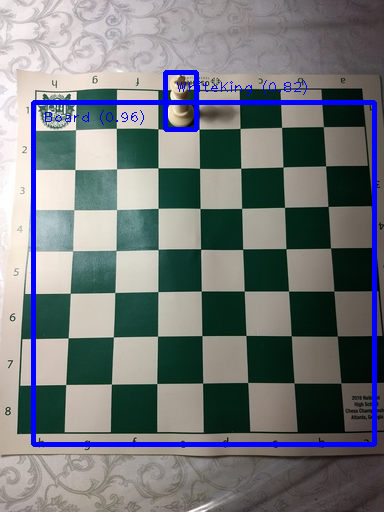

In [7]:
#@title Run object detection and show the detection results

from PIL import Image

INPUT_IMAGE_URL = "/content/drive/My Drive/Technology fair/Images/test/IMG_20220118_205730005.jpg" #@param {type:"string"}
DETECTION_THRESHOLD = 0.2 #@param {type:"number"}
TFLITE_MODEL_PATH1 = "pieces.tflite" #@param {type:"string"}
TFLITE_MODEL_PATH2 = "board.tflite" #@param {type:"string"}

TEMP_FILE = '/content/tmp/IMG_20220119_175646469.jpg'
# TEMP_FILE = '/content/tmp/IMG_20220118_205730005.jpg'

# !wget -q -O "/content/tmp/image.jpg" "/content/images/validate/IMG_20220108_202502072.jpg"
image = Image.open(TEMP_FILE).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector1 = ObjectDetector(model_path=TFLITE_MODEL_PATH1, options=options)
detector2 = ObjectDetector(model_path=TFLITE_MODEL_PATH2, options=options)

# Run object detection estimation using the model.
detections1 = detector1.detect(image_np)
detections2 = detector2.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections1+detections2)

# Show the detection result
Image.fromarray(image_np)